In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v3'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0901_030634'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 6019


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            model.metrics.update(pred,batch)
            # pred['mid_output']['sampled_feats'].retain_grad()
            # loss = model.loss_func(pred,batch)
            # loss[0].backward()
            # vis_result = viz(batch,pred)
    # if i ==5:
            break   
        
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)
# model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Prediction')

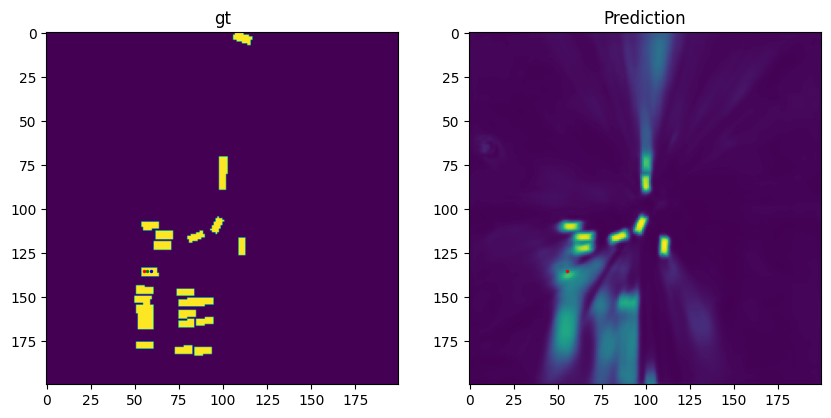

In [ ]:
batch_index = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
y = 135
x = 55
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[batch_index,0].detach().cpu().numpy())
ax1.scatter([x],[y], s=2, c='r')
ax1.scatter([x+2],[y], s=2, c='g')
ax1.scatter([x+4],[y], s=2, c='b')
ax1.set_title('gt')

ax2.imshow(((pred['VEHICLE'][batch_index,0].sigmoid().detach().cpu())).numpy())
ax2.scatter([x],[y], s=2, c='r')
ax2.set_title('Prediction')
# plt.title('2D')

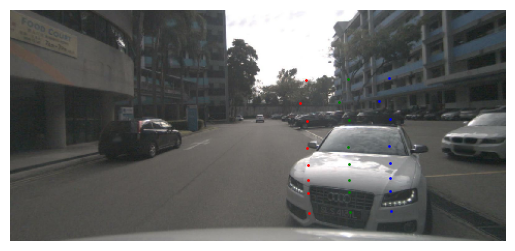

In [ ]:
x = [[[0.7680, 0.8677]],

        [[0.7653, 0.7809]],

        [[0.7657, 0.7265]],

        [[0.7641, 0.6602]],

        [[0.7638, 0.5873]],

        [[0.7655, 0.4686]],

        [[0.7427, 0.3912]],

        [[0.7627, 0.2928]]]
y= [[[0.6847, 0.8737]],

        [[0.6823, 0.7868]],

        [[0.6829, 0.7325]],

        [[0.6815, 0.6664]],

        [[0.6807, 0.5935]],

        [[0.6819, 0.4747]],

        [[0.6626, 0.3968]],

        [[0.6795, 0.2981]]]

z= [[[0.6013, 0.8774]],

        [[0.5993, 0.7904]],

        [[0.5999, 0.7361]],

        [[0.5988, 0.6701]],

        [[0.5974, 0.5971]],

        [[0.5982, 0.4784]],

        [[0.5830, 0.4001]],

        [[0.5961, 0.3013]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224

y = np.array(y)[:,0]
y[:, 0] *= 480
y[:, 1] *= 224

z = np.array(z)[:,0]
z[:, 0] *= 480
z[:, 1] *= 224

plt.imshow(batch['image'][0,4].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1],s=1, c='b')
plt.scatter(y[:,0],y[:,1],s=1, c='g')
plt.scatter(z[:,0],z[:,1],s=1, c='r')
plt.axis('off')
plt.show()

tensor(0.0373)
tensor(0.5297)
tensor(0.2139)
tensor(0.1248)
tensor(0.0672)
tensor(0.0153)
tensor(0.0085)
tensor(0.0034)


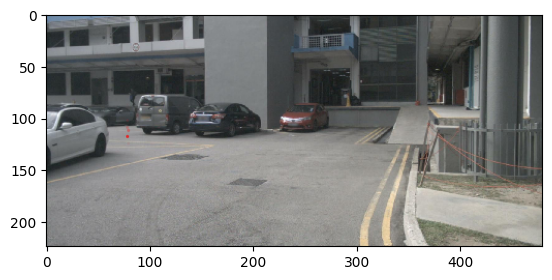

In [ ]:
att_ = [[[6.5340e-02, 5.3824e-02, 7.1003e-02, 8.9783e-02, 1.0052e-01,
          2.1674e-01, 2.4850e-01, 1.5429e-01]],

        [[8.4533e-01, 2.9125e-02, 7.4905e-03, 3.9165e-03, 8.7952e-03,
          2.9696e-02, 3.2924e-02, 4.2719e-02]],

        [[3.7292e-02, 5.2968e-01, 2.1391e-01, 1.2478e-01, 6.7188e-02,
          1.5254e-02, 8.5465e-03, 3.3540e-03]],

        [[9.9554e-01, 3.0242e-03, 4.2843e-04, 1.5751e-04, 7.1936e-05,
          4.4035e-04, 3.1095e-04, 3.0371e-05]]]
att_ = torch.tensor(att_)[:, 0]
# _, att_ = torch.sort(att_, 1)

x = [[[0.1639, 0.5506]],

        [[0.1630, 0.5193]],

        [[0.1633, 0.4945]],

        [[0.1624, 0.4804]],

        [[0.1628, 0.4522]],

        [[0.1622, 0.3819]],

        [[0.1621, 0.3487]],

        [[0.1620, 0.3103]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224
head_index = 2
plt.imshow(batch['image'][0,3].cpu().permute(1,2,0))
for i in range(8):
    print(att_[head_index,i])
    plt.scatter(x[i,0], x[i,1], s=2, alpha=float(att_[head_index,i]), c='r')

In [ ]:
plt.imshow(vis_result[0])

In [ ]:
from nuscenes.nuscenes import NuScenes

# Load the nuScenes dataset (mini-split, in this case).
nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=False)

In [ ]:
for batch in loader:
    break
nusc.render_sample(batch['token'][0])

In [ ]:
# viz.label_indices = [4, 5, 6, 7,8,9,10,11]
# from cross_view_transformer.visualizations.common import get_colors
# SEMANTICS = [viz.SEMANTICS[i] for i in viz.label_indices]
# viz.colors = get_colors(SEMANTICS)
for batch in loader:
    break
plt.imshow(viz.visualize_bev(batch['bev'][0], batch['view'][0].numpy()))
# plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.axis('off')

In [ ]:
plt.imshow(viz(batch)[0])

In [ ]:
a = torch.rand((4, 40000, 1, 8, 128))
a = a.reshape(4 *40000,8, 128)
attention = nn.MultiheadAttention(128, 4, batch_first=True)
attention(a, a, a)

In [ ]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v[None]
# with torch.no_grad():
#     pred = network(batch)
pred = None
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

In [ ]:
plt.imshow(pred['VEHICLE'][0,0].sigmoid())

In [ ]:
a = np.random.rand((5))
print(a)

In [ ]:
(a > 0.6).all()

In [ ]:
for i,batch in enumerate(loader):
    break
img = batch['bev']
print(img.shape)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[0,0])
vehicles = F.interpolate(vehicles, size=[25,25], mode='bilinear')
ax2.imshow(vehicles[0,0])

In [ ]:
vehicles = F.interpolate(vehicles, size=[200,200], mode='bilinear')
plt.imshow(vehicles[0,0])

In [ ]:
import torch.nn as nn
import torch
x = torch.rand((4,20,20,128))
x = torch.split(x, 64, -1)
print(x[0].shape, x[1].shape)

torch.Size([4, 20, 20, 64]) torch.Size([4, 20, 20, 64])


In [ ]:
torch.linspace(-0.25, 1.25, 8).sigmoid() * 8 - 4

tensor([-0.4974, -0.0714,  0.3562,  0.7758,  1.1783,  1.5563,  1.9042,  2.2184])